# DiscreteDP Example: Job Search

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

We study an optimal stopping problem, in the context of job search as discussed in
[http://quant-econ.net/py/lake_model.html](http://quant-econ.net/py/lake_model.html).

In [1]:
using QuantEcon
import QuantEcon: solve
using Distributions
using PyPlot
using Roots

## Optimal solution

We skip the description of the model, just writing down the Bellman equation:
$$
\begin{aligned}
U   &= u(c) + \beta \left[(1 - \gamma) U + \gamma E[V_s]\right], \\
V_s &= \max\left\{U,
                  u(w_s) + \beta \left[(1 - \alpha) V_s + \alpha U\right]
           \right\}.
\end{aligned}
$$
For this class of problem, we can characterize the solution analytically.

The optimal policy $\sigma^*$ is monotone;
it is characterized by a threshold $s^*$, for which
$\sigma^*(s) = 1$ if and only if $s \geq s^*$,
where actions $0$ and $1$ represent "reject" and "accept", respectively.
The threshold is defined as follows:
Let
$$
\begin{aligned}
g(s) &= u(w_s) - u(c), \\
h(s) &= \frac{\beta \gamma}{1 - \beta (1 - \alpha)}
        \sum_{s' \geq s} p_s u(w_s).
\end{aligned}
$$
It is easy to see that $g$ is increasing and $h$ is decreasing.
Then the threshold $s^*$ is such that $s \geq s^*$ if and only if $g(s) > h(s)$.

Given $s^*$, the optimal values can be computed as follows:
$$
\begin{aligned}
U &=
\frac{\{1 - (1 - \alpha) \beta\} u(c) + \beta \gamma \sum_{s \geq s^*} p_s u(w_s)}
     {(1 - \beta) \left[\{1 - (1 - \alpha) \beta\} +
                        \beta \gamma \sum_{s \geq s^*} p_s\right]}, \\
V_s &=
\begin{cases}
U & \text{if $s < s^*$} \\
\dfrac{u(w_s) + \alpha \beta U}{1 - (1 - \alpha) \beta} & \text{if $s \geq s^*$}.
\end{cases}
\end{aligned}
$$

The optimal policy defines a Markov chain over $\{\text{unemployed}, \text{employed}\}$.
Its stationary distribution is
$\pi = \left(\frac{\alpha}{\alpha + \lambda}, \frac{\lambda}{\alpha + \lambda}\right)$,
where
$\lambda = \gamma \sum_{s \geq s^*} p(w_s)$;
note that the flow from unemployed to employed is $\lambda$,
while the flow from employed to unemployed is $\alpha$.

The expected value at the stationary distribution is
$$
\pi_0 U + \pi_1 \frac{\sum_{s \geq s^*} p_s V_s}{\sum_{s \geq s^*} p_s}.
$$

The above analytical solution aside,
we solve the job search problem using the `DiscreteDP` type:

In [2]:
type JobSearchModel
    # Parameters
    w::Vector{Float64}
    w_pdf::Vector{Float64}
    beta::Real
    alpha::Real
    gamma::Real
    rho::Real
    # Internal variables
    u::Function
    ddp::DiscreteDP
    num_states::Integer
    num_actions::Integer
    rej::Integer
    acc::Integer
    
    function JobSearchModel(w::Vector, w_pdf::Vector, beta::Real;
                            alpha::Real=0, gamma::Real=1, rho::Real=0)
        # Utility function
        function u(y::Vector{Float64})
            small_number = -9999999
            nonpositive = (y .<= 0)
            if rho == 1
                util = log(y)
            else
                util = (y.^(1 - rho) - 1)/(1 - rho)
            end
            util[nonpositive] = small_number
            return util
        end
        u_w = u(w)
        
        num_states = length(w) + 1
        num_actions = 2
        rej, acc = 1, 2
        
        # Reward array
        R0 = zeros(num_states, num_actions)
        R0[1:end-1, acc] = u_w
        
        # Transition probability array
        Q = zeros(num_states, num_actions, num_states)
        # Reject
        for s in 1:num_states
            Q[s, rej, 1:end-1] = w_pdf * gamma
            Q[s, rej, end] = 1 - gamma
        end
        # Accept
        for s in 1:num_states-1
            Q[s, acc, s] = 1 - alpha
            Q[s, acc, end] = alpha
        end
        Q[end, acc, 1:end-1] = w_pdf
        
        ddp = DiscreteDP(R0, Q, beta)
        
        js = new(w, w_pdf, beta, alpha, gamma, rho, u, ddp,
                 num_states, num_actions, rej, acc)
        return js
    end
end

function solve(js::JobSearchModel, c::Float64)
    n, m = js.num_states, js.num_actions
    rej = js.rej
    js.ddp.R[:, rej] = js.u([c])[1]
    js.ddp.R[end, :] = js.u([c])[1]
    
    res = solve(js.ddp, PFI)
    V = res.v[1:end-1]  # Values of jobs
    U = res.v[end]  # Value of unemployed
    C = ind2sub(js.ddp, res.sigma)[1:end-1] - 1  # Optimal policy
    
    lamb = dot(js.w_pdf, C) * js.gamma
    pi = [js.alpha, lamb]
    pi /= sum(pi)  # Stationary distribution
    
    return V, U, C, pi
end;

The following paramter values are from [lakemodel_example.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/examples/lakemodel_example.py).

In [3]:
w = linspace(0, 175, 201)  # wage grid

# compute probability of each wage level 
logw_dist = Normal(log(20), 1)
logw_dist_cdf = cdf(logw_dist, log(w))
logw_dist_pdf = logw_dist_cdf[2:end] - logw_dist_cdf[1:end-1]
logw_dist_pdf /= sum(logw_dist_pdf)
w = Array((w[2:end] + w[1:end-1])/2);

In [4]:
gamma = 1.
alpha = 0.013  # Monthly
alpha_q = (1-(1-alpha)^3)  # Quarterly
beta = 0.99
rho = 2  # risk-aversion;

In [5]:
js = JobSearchModel(w, logw_dist_pdf, beta, alpha=alpha_q, gamma=gamma, rho=rho);

Take a look at the optimal solution for $c = 40$ for example:

In [6]:
c = 40.
V, U, C, pi = solve(js, c);

In [7]:
s_star = length(w) - sum(C) + 1
println("Optimal policy: Accept if and only if w >= $(w[s_star])")

Optimal policy: Accept if and only if w >= 65.1875


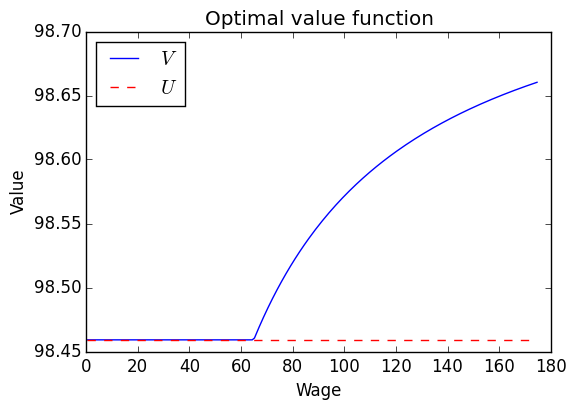

In [8]:
fig, ax = subplots(figsize=(6, 4))
ax[:plot](w, V, label=L"$V$")
ax[:plot]((w[1], w[end]), (U, U), "r--", label=L"$U$")
ax[:set_title]("Optimal value function")
ax[:set_xlabel]("Wage")
ax[:set_ylabel]("Value")
legend(loc=2)
show()

## Optimal unemployment insurance policy

We compute the optimal level of unemployment insurance
as in the [lecture](http://quant-econ.net/py/lake_model.html#fiscal-policy),
mimicking [lakemodel_example.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/examples/lakemodel_example.py).

In [9]:
type UnemploymentInsurancePolicy
    w::Vector{Float64}
    w_pdf::Vector{Float64}
    beta::Real
    alpha::Real
    gamma::Real
    rho::Real
    
    function UnemploymentInsurancePolicy(w::Vector, w_pdf::Vector, beta::Real;
                                         alpha::Real=0, gamma::Real=1, rho::Real=0)
        js = new(w, w_pdf, beta, alpha_q, gamma, rho)
        return js
    end
end

function solve_job_search_model(uip::UnemploymentInsurancePolicy,
                                c::Float64, T::Float64)
    js = JobSearchModel(uip.w-T, uip.w_pdf, uip.beta,
                        alpha=uip.alpha, gamma=uip.gamma, rho=uip.rho)
    V, U, C, pi = solve(js, c-T)
    return V, U, C, pi
end

function implement(uip::UnemploymentInsurancePolicy, c::Float64)
    
    function budget_balance(T::Float64)
        V, U, C, pi = solve_job_search_model(uip, c, T)
        return T - pi[1]*c
    end
    
    # Budget balancing tax given c
    T = fzero(budget_balance, 0.)
    
    V, U, C, pi = solve_job_search_model(uip, c, T)
    
    EV = dot(C .* V, uip.w_pdf) / (dot(C, uip.w_pdf))
    W = pi[1] * U + pi[2] * EV
    
    return T, W, pi
end;

In [10]:
uip = UnemploymentInsurancePolicy(w, logw_dist_pdf, beta,
                                  alpha=alpha_q, gamma=gamma, rho=rho);

In [11]:
grid_size = 26
cvec = linspace(5, 135, grid_size)
Ts, Ws = Array(Float64, grid_size), Array(Float64, grid_size)
pis = Array(Float64, 2, grid_size)

for (i, c) in enumerate(cvec)
    T, W, pi = implement(uip, c)
    Ts[i], Ws[i], pis[:, i] = T, W, pi
end
i_max = indmax(Ws)
println("Optimal unemployment benefit: $(cvec[i_max])")

Optimal unemployment benefit: 67.4


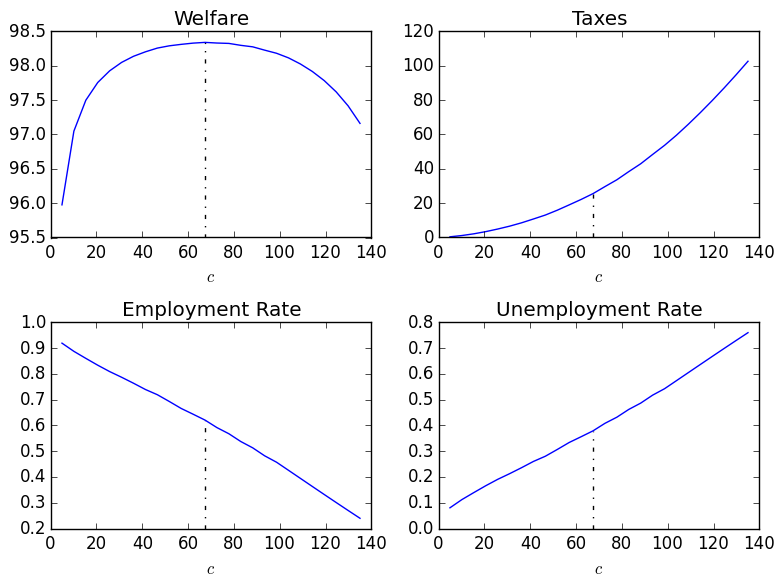

In [12]:
function plot(ax, y_vec, title)
    ax[:plot](cvec, y_vec)
    ax[:set_xlabel](L"$c$")
    ax[:vlines](cvec[i_max], ax[:get_ylim]()[1], y_vec[i_max], "k", "-.")
    ax[:set_title](title)
end

fig, axes = subplots(2, 2)
plot(axes[1, 1], Ws, "Welfare")
plot(axes[1, 2], Ts, "Taxes")
plot(axes[2, 1], vec(pis[2, :]), "Employment Rate")
plot(axes[2, 2], vec(pis[1, :]), "Unemployment Rate")

tight_layout()
show()

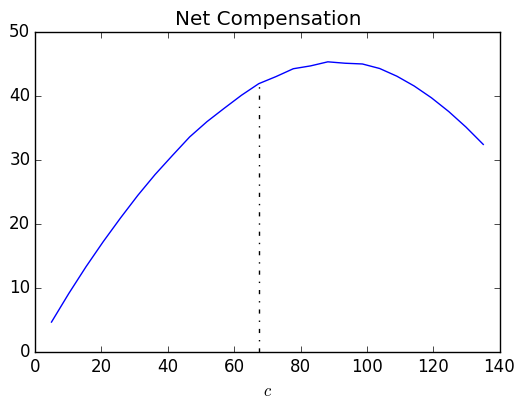

In [13]:
fig, ax = subplots(figsize=(6, 4))
plot(ax, cvec-Ts, "Net Compensation")
show()